# Functions

In [136]:
import datetime as dt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import swifter
from pprint import pprint
import numpy as np

In [137]:
def bpy_color_palette(n=50, cutoff_tails=0.1):
    """
    Generate a color palette with specific number.
    Ref. https://www.rdocumentation.org/packages/gstat/versions/0.9-22/topics/bpy.colors

    Args:
        n (int): number of colors
        cutoff_tails (float): tail fraction to be cut off. This palette runs from black to white if cutoff.tails is 0; by cutting off the tails, it runs from blue to yellow, which looks nicer.
    Returns:
        color_list (list): list of hex color code.
    """
    item_list = np.linspace(start=0.5 * cutoff_tails, stop=1 - 0.5 * cutoff_tails, num=n)
    color_list = []
    for i in item_list:
        ### R
        if(i < 0.25):
            r = 0
        elif(i < 0.57):
            r =  i / .32 - .78125
        else:
            r = 1
        ### G
        if(i < 0.42):
            g = 0
        elif(i < 0.92):
            g =  2 * i - .84
        else:
            g = 1
        ### B
        if(i < 0.25):
            b = 4 * i
        elif(i < 0.42):
            b =  1
        elif(i < 0.92):
            b =  -2 * i + 1.84
        else:
            b = i / .08 - 11.5
        ### append color
        color_list.append(matplotlib.colors.to_hex([ r, g, b ]))
    cmap = matplotlib.colors.ListedColormap(color_list, name='my_colormap')
    return cmap

In [138]:
def mi_event_parsing(miinfofile):
    def nr_pci_track():
        if miinfofile.loc[i, "PCI"] == 65535: ## 65535 is for samgsung phone.
            nr_pci = '-'
        else:
            nr_pci = miinfofile.loc[i, "PCI"]
        return nr_pci

    nr_pci = None ## Initial Unknown
     
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    eNB_to_MN_list = []
    MN_to_eNB_list = []
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list_type2 = [] #eNB handover failure
    reestablish_list_type3 = []
    
    SCell_rel = []
    SCell_add = []
    SCell_add_rel = []

    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    lte_failure = 0
    lte_failure_start_index = None
    
    handover_num = 0
    
    for i in range(len(miinfofile)):
        if miinfofile.loc[i, "type_id"] == "5G_NR_RRC_OTA_Packet":
            nr_pci = nr_pci_track()
            continue
            
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and not nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            

        if lte_handover and not nr_handover and nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:    # LTE Ho and nr release 
            lte_handover = 0
            nr_release = 0
            MN_to_eNB_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
        
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_physCellId"]: 
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            else:
                ##############
                if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                    eNB_to_MN_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])       
                else:
                    nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            
        if not lte_handover and  nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "Timestamp"], miinfofile.loc[i, "Timestamp"]]) 
            
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            if lte_failure == 0:
                lte_failure = 1
                lte_failure_start_index = i
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentComplete"]:
            lte_failure = 0
            reestablish_list_type2.append([miinfofile.loc[lte_failure_start_index, "Timestamp"], miinfofile.loc[lte_failure_start_index, "Timestamp"]])
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentReject"]:
            lte_failure = 0
            reestablish_list_type3.append([miinfofile.loc[lte_failure_start_index, "Timestamp"], miinfofile.loc[lte_failure_start_index, "Timestamp"]])
        
        # if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0' and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0):
        #     SCell_rel.append([miinfofile.loc[i, "Timestamp"]])
                              # May change        
        # if miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
        #     SCell_add.append([miinfofile.loc[i, "Timestamp"]])
        #                                                                                                                                    # May change
        # if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0'and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0) and miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
        #     SCell_add_rel.append([miinfofile.loc[i, "Timestamp"], miinfofile.loc[i, "Timestamp"]])


    # return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, 
    # reestablish_list_type2, reestablish_list_type3, SCell_rel, SCell_add, SCell_add_rel], handover_num
    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, 
            nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, reestablish_list_type2, 
            reestablish_list_type3], handover_num

def parse_handover(df):
    def nr_pci_track(mode=1):
        if mode:
            # if df.loc[i, "PCI"] == 65535:  ## 65535 is for samgsung phone.
            if df.loc[i, "PCI"] in [0, 65535]:  ## 65535 is for samgsung phone, 0 is for xiaomi phone.
                nr_pci = '-'
                nr_freq = '-'
            else:
                nr_pci = str(round(df.loc[i, "PCI"]))
                nr_freq = str(round(df.loc[i, "Freq"]))
        else:
            # if df.loc[i, "PCI"] == 65535:  ## 65535 is for samgsung phone.
            if df.loc[k, "PCI"] in [0, 65535]:  ## 65535 is for samgsung phone, 0 is for xiaomi phone.
                nr_pci = '-'
                nr_freq = '-'
            else:
                nr_pci = str(round(df.loc[k, "PCI"]))
                nr_freq = str(round(df.loc[k, "Freq"]))
        return nr_pci, nr_freq
    
    def eci_track(mode=1):
        if mode:
            eci = df.loc[i, "Cell Identity"]
        else:
            eci = df.loc[k, "Cell Identity"]
        return eci
    
    # df = pd.read_csv(fin)
    # df.loc[:, 'Timestamp'] = pd.to_datetime(df.loc[:, 'Timestamp']) + dt.timedelta(hours=8)
    # df['Timestamp'] = pd.to_datetime(df['Timestamp']) + dt.timedelta(hours=8)
    if len(df):
        exp_time = (df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]).total_seconds()
    else:
        exp_time = 0

    ### add new columns
    newCols = ['handoff_type', 'handoff_state', 'handoff_duration', 'nr_PCI', 'nr_Freq', 'eNB.ID', 'CID']
    df = df.reindex(df.columns.tolist() + newCols, axis=1)
    
    ### filter by packet type
    # key = (df.loc[:, 'type_id'] == 'LTE_RRC_OTA_Packet') | (df.loc[:, 'type_id'] == '5G_NR_RRC_OTA_Packet') | (df.loc[:, 'type_id'] == 'LTE_RRC_Serv_Cell_Info')
    # df = df.loc[key]
    # df = df.reset_index(drop=True)

    ### Initialization
    # ePCI = earfcn = nr_PCI = nr_arfcn = '-'
    # eNB = CID = TAC = MCC = MNC = '-'

    ### Successful Handover
    lte_handover_list = []        # (eNB1)       -> (eNB2)            # lte_handoff_4G (in pure LTE)
    SN_addition_list = []         # (eNB)        -> (eNB, gNB)        # nr_setup (addition, pure LTE to EN-DC)
    SN_removal_list = []          # (eNB, gNB)   -> (eNB)             # nr_release (removal, EN-DC to pure LTE)
    endc_SN_change_list = []      # (eNB, gNB1)  -> (eNB, gNB2)       # nr_handoff_5G (in EN-DC)
    endc_MN_change_list = []      # (eNB1, gNB)  -> (eNB2, gNB)       # lte_handoff_5G (in EN-DC)
    endc_MNSN_change_list = []    # (eNB1, gNB1) -> (eNB2, gNB2)      # nr_lte_handoff_5G (in EN-DC)
    lte2endc_MN_change_list = []  # (eNB1)       -> (eNB2, gNB)       # eNB_to_MN (pure LTE to EN-DC)
    endc2lte_MN_change_list = []  # (eNB1, gNB)  -> (eNB2)            # MN_to_eNB (EN-DC to pure LTE)
    ### Handover Failure
    scg_failure_list = []         # gNB handover (SN change) failure  # scg_failure
    radio_link_failure_list = []  # eNB handover (MN change) failure  # reestablish_type2
    nas_recovery_list = []        # re-establishment reject           # reestablish_type3
    
    ### Initializing...
    nr_pci = '-'
    nr_freq = '-'
    post_nr_pci = '-'
    post_nr_freq = '-'
    eci = '-'
    handover_num = 0
    ### Successful handover
    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    nr_reserved = 0
    ### Handover failure
    lte_failure = 0
    lte_failure_start_index = None

    for i in range(len(df)):
    
        if df.loc[i, "type_id"] == "5G_NR_RRC_OTA_Packet" and not nr_reserved:
            nr_pci, nr_freq = nr_pci_track()
            if df.loc[i, "nr-rrc.t304"]:
                post_nr_pci = df.loc[i, "nr_physCellId"]
                post_nr_freq = df.loc[i, "ssbFrequency"] if df.loc[i, "ssbFrequency"] else nr_freq
                nr_reserved = 1
            continue
        if df.loc[i, "type_id"] == "LTE_RRC_Serv_Cell_Info":
            eci = eci_track()
            continue
        
        if df.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
        if df.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
        if df.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
        if (nr_handover or lte_handover or nr_release) and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num += 1
        
        ### Successful handover message classifying
        ### Involves LTE handover and / or NR release
        if lte_handover and not nr_handover and not nr_release and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            lte_handover = 0
            nr_reserved = 0
            df.loc[lte_handover_start_index, 'handoff_type'] = 'lte_handover'
            df.loc[lte_handover_start_index, 'handoff_state'] = 'start'
            df.loc[lte_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            df.loc[lte_handover_start_index, 'nr_PCI'] = nr_pci
            df.loc[lte_handover_start_index, 'nr_Freq'] = nr_freq
            df.loc[lte_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[lte_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
            df.loc[i, 'handoff_type'] = 'lte_handover'
            df.loc[i, 'handoff_state'] = 'end'
            df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            k = i
            post_nr_pci, post_nr_freq = nr_pci, nr_freq
            while df.loc[k, 'type_id'] != "5G_NR_RRC_OTA_Packet":
                k += 1
                if k == len(df):
                    k = i
                    break
            if k != i:
                post_nr_pci, post_nr_freq = nr_pci_track(0)
                nr_pci, nr_freq = post_nr_pci, post_nr_freq
            df.loc[i, 'nr_PCI'] = post_nr_pci
            df.loc[i, 'nr_Freq'] = post_nr_freq
            k = i
            while df.loc[k, 'type_id'] != "LTE_RRC_Serv_Cell_Info":
                k += 1
                if k == len(df) or df.loc[k, 'lte-rrc.t304'] == 1:
                    k = i
                    break
            if k != i:
                eci = eci_track(0)
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            lte_handover_list.append((df.loc[lte_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
            # lte_handover_list.append(1)
        elif lte_handover and not nr_handover and nr_release and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            lte_handover = 0
            nr_release = 0
            nr_reserved = 0
            df.loc[lte_handover_start_index, 'handoff_type'] = 'endc2lte_MN_change'
            df.loc[lte_handover_start_index, 'handoff_state'] = 'start'
            df.loc[lte_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            df.loc[lte_handover_start_index, 'nr_PCI'] = nr_pci
            df.loc[lte_handover_start_index, 'nr_Freq'] = nr_freq
            df.loc[lte_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[lte_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
            df.loc[i, 'handoff_type'] = 'endc2lte_MN_change'
            df.loc[i, 'handoff_state'] = 'end'
            df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            df.loc[i, 'nr_PCI'] = post_nr_pci
            df.loc[i, 'nr_Freq'] = post_nr_freq
            k = i
            while df.loc[k, 'type_id'] != "LTE_RRC_Serv_Cell_Info":
                k += 1
                if k == len(df) or df.loc[k, 'lte-rrc.t304'] == 1:
                    k = i
                    break
            if k != i:
                eci = eci_track(0)
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            endc2lte_MN_change_list.append((df.loc[lte_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
            # endc2lte_MN_change_list.append(1)
            # nr_pci == '-'
        ### Involves only NR handover (including NR setup)
        elif nr_handover and not lte_handover and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_handover = 0
            nr_reserved = 0
            if df.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:  # This if-else statement classifies whether it is nr addition or nr handover
                df.loc[nr_handover_start_index, 'handoff_type'] = 'SN_addition'
                df.loc[nr_handover_start_index, 'handoff_state'] = 'start'
                df.loc[nr_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[nr_handover_start_index, 'nr_PCI'] = nr_pci
                df.loc[nr_handover_start_index, 'nr_Freq'] = nr_freq
                df.loc[nr_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[nr_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
                df.loc[i, 'handoff_type'] = 'SN_addition'
                df.loc[i, 'handoff_state'] = 'end'
                df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[i, 'nr_PCI'] = post_nr_pci
                df.loc[i, 'nr_Freq'] = post_nr_freq
                df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
                SN_addition_list.append((df.loc[nr_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
                # SN_addition_list.append(1)
            else:
                df.loc[nr_handover_start_index, 'handoff_type'] = 'endc_SN_change'
                df.loc[nr_handover_start_index, 'handoff_state'] = 'start'
                df.loc[nr_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[nr_handover_start_index, 'nr_PCI'] = nr_pci
                df.loc[nr_handover_start_index, 'nr_Freq'] = nr_freq
                df.loc[nr_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[nr_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
                df.loc[i, 'handoff_type'] = 'endc_SN_change'
                df.loc[i, 'handoff_state'] = 'end'
                df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[i, 'nr_PCI'] = post_nr_pci
                df.loc[i, 'nr_Freq'] = post_nr_freq
                df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
                endc_SN_change_list.append((df.loc[nr_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
                # endc_SN_change_list.append(1)
                
            ### Additional Judgement
            # if df.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #     print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            # if df.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != df.loc[nr_handover_start_index, "nr_pci"]): 
            #     print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, df.loc[nr_handover_start_index, "nr_pci"], nr_pci)
            
            ### nr_pci update
            # nr_pci = df.loc[nr_handover_start_index, "nr_pci"]

        ### Involves both LTE & NR handover (including NR setup)
        elif lte_handover and nr_handover and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            lte_handover = 0
            nr_handover = 0
            nr_reserved = 0
            # print(type(nr_pci))
            # print(type(df.loc[lte_handover_start_index, "nr_physCellId"]))
            # if nr_pci == df.loc[lte_handover_start_index, "nr_pci"]:
            if nr_pci == str(round(df.loc[lte_handover_start_index, "nr_physCellId"])): 
                df.loc[lte_handover_start_index, 'handoff_type'] = 'endc_MN_change'
                df.loc[lte_handover_start_index, 'handoff_state'] = 'start'
                df.loc[lte_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[lte_handover_start_index, 'nr_PCI'] = nr_pci
                df.loc[lte_handover_start_index, 'nr_Freq'] = nr_freq
                df.loc[lte_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[lte_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
                df.loc[i, 'handoff_type'] = 'endc_MN_change'
                df.loc[i, 'handoff_state'] = 'end'
                df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
                df.loc[i, 'nr_PCI'] = nr_pci
                df.loc[i, 'nr_Freq'] = nr_freq
                k = i
                while df.loc[k, 'type_id'] != "LTE_RRC_Serv_Cell_Info":
                    k += 1
                    if k == len(df) or df.loc[k, 'lte-rrc.t304'] == 1:
                        k = i
                        break
                if k != i:
                    eci = eci_track(0)
                df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
                endc_MN_change_list.append((df.loc[lte_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
                # endc_MN_change_list.append(1)
            else:
                if df.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:  # This if-else statement classifies whether it is nr addition or nr handover
                    df.loc[nr_handover_start_index, 'handoff_type'] = 'lte2endc_MN_change'
                    df.loc[nr_handover_start_index, 'handoff_state'] = 'start'
                    df.loc[nr_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                    df.loc[nr_handover_start_index, 'nr_PCI'] = nr_pci
                    df.loc[nr_handover_start_index, 'nr_Freq'] = nr_freq
                    df.loc[nr_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                    df.loc[nr_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
                    df.loc[i, 'handoff_type'] = 'lte2endc_MN_change'
                    df.loc[i, 'handoff_state'] = 'end'
                    df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_handover_start_index, "Timestamp"]).total_seconds()
                    df.loc[i, 'nr_PCI'] = post_nr_pci
                    df.loc[i, 'nr_Freq'] = post_nr_freq
                    k = i
                    while df.loc[k, 'type_id'] != "LTE_RRC_Serv_Cell_Info":
                        k += 1
                        if k == len(df) or df.loc[k, 'lte-rrc.t304'] == 1:
                            k = i
                            break
                    if k != i:
                        eci = eci_track(0)
                    df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                    df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
                    lte2endc_MN_change_list.append((df.loc[nr_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
                    # lte2endc_MN_change_list.append(1)
                else:
                    df.loc[lte_handover_start_index, 'handoff_type'] = 'endc_MNSN_change'
                    df.loc[lte_handover_start_index, 'handoff_state'] = 'start'
                    df.loc[lte_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
                    df.loc[lte_handover_start_index, 'nr_PCI'] = nr_pci
                    df.loc[lte_handover_start_index, 'nr_Freq'] = nr_freq
                    df.loc[lte_handover_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                    df.loc[lte_handover_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
                    df.loc[i, 'handoff_type'] = 'endc_MNSN_change'
                    df.loc[i, 'handoff_state'] = 'end'
                    df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
                    df.loc[i, 'nr_PCI'] = post_nr_pci
                    df.loc[i, 'nr_Freq'] = post_nr_freq
                    k = i
                    while df.loc[k, 'type_id'] != "LTE_RRC_Serv_Cell_Info":
                        k += 1
                        if k == len(df) or df.loc[k, 'lte-rrc.t304'] == 1:
                            k = i
                            break
                    if k != i:
                        eci = eci_track(0)
                    df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
                    df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
                    endc_MNSN_change_list.append((df.loc[lte_handover_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
                    # endc_MNSN_change_list.append(1)
            
            ### nr_pci update
            # nr_pci = df.loc[lte_handover_start_index, "nr_pci"]

        ### Involves only NR release
        # if nr_release and df.loc[i, "rrcConnectionReconfigurationComplete"]:
        elif not lte_handover and nr_release and df.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_release = 0
            nr_reserved = 0
            # if lte_handover:
            #     df.loc[lte_handover_start_index, 'handoff_type'] = 'endc2lte_MN_change'
            #     df.loc[lte_handover_start_index, 'handoff_state'] = 'start'
            #     df.loc[lte_handover_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            #     df.loc[i, 'handoff_type'] = 'endc2lte_MN_change'
            #     df.loc[i, 'handoff_state'] = 'end'
            #     df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[lte_handover_start_index, "Timestamp"]).total_seconds()
            #     endc2lte_MN_change_list.append(1)
            # else:
            df.loc[nr_release_start_index, 'handoff_type'] = 'SN_removal'
            df.loc[nr_release_start_index, 'handoff_state'] = 'start'
            df.loc[nr_release_start_index, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_release_start_index, "Timestamp"]).total_seconds()
            df.loc[nr_release_start_index, 'nr_PCI'] = nr_pci
            df.loc[nr_release_start_index, 'nr_Freq'] = nr_freq
            df.loc[nr_release_start_index, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[nr_release_start_index, 'CID'] = eci % 256 if eci != '-' else '-'
            df.loc[i, 'handoff_type'] = 'SN_removal'
            df.loc[i, 'handoff_state'] = 'end'
            df.loc[i, 'handoff_duration'] = (df.loc[i, "Timestamp"] - df.loc[nr_release_start_index, "Timestamp"]).total_seconds()
            df.loc[i, 'nr_PCI'] = post_nr_pci
            df.loc[i, 'nr_Freq'] = post_nr_freq
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            SN_removal_list.append((df.loc[nr_release_start_index, "Timestamp"], df.loc[i, "Timestamp"]))
            # SN_removal_list.append(1)

            ### reset nr_pci
            # nr_pci = '-'
        
        ### Handover failure classifying
        if df.loc[i, "scgFailureInformationNR-r15"]:  ## nr_failure
            df.loc[i, 'handoff_type'] = 'scg_failure'
            df.loc[i, 'handoff_state'] = 'trigger'
            df.loc[i, 'nr_PCI'] = df.loc[i, "nr_physCellId"] if df.loc[i, "nr_physCellId"] else nr_pci   # report the failed target nr_pci
            df.loc[i, 'nr_Freq'] = df.loc[i, "ssbFrequency"] if df.loc[i, "nr_physCellId"] else nr_freq  # report the failed target nr_freq
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            # df.loc[i, 'nr_PCI'] = nr_pci    # report the original nr_pci
            # df.loc[i, 'nr_Freq'] = nr_freq  # report the original nr_freq
            scg_failure_list.append((df.loc[i, "Timestamp"], df.loc[i, "Timestamp"]))
            # scg_failure_list.append(1)
        
        if df.loc[i, "rrcConnectionReestablishmentRequest"]:
            if lte_failure == 0:
                lte_failure = 1
                lte_failure_start_index = i
        
        if lte_failure and df.loc[i, "rrcConnectionReestablishmentComplete"]:
            lte_failure = 0
            df.loc[lte_failure_start_index, 'handoff_type'] = 'radio_link_failure'
            df.loc[lte_failure_start_index, 'handoff_state'] = 'trigger'
            df.loc[lte_failure_start_index, 'nr_PCI'] = nr_pci    # report the original nr_pci
            df.loc[lte_failure_start_index, 'nr_Freq'] = nr_freq  # report the original nr_freq
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            radio_link_failure_list.append((df.loc[lte_failure_start_index, "Timestamp"], df.loc[lte_failure_start_index, "Timestamp"]))
            # radio_link_failure_list.append(1)
        
        elif lte_failure and df.loc[i, "rrcConnectionReestablishmentReject"]:
            lte_failure = 0
            df.loc[lte_failure_start_index, 'handoff_type'] = 'nas_recovery'
            df.loc[lte_failure_start_index, 'handoff_state'] = 'trigger'
            df.loc[lte_failure_start_index, 'nr_PCI'] = nr_pci    # report the original nr_pci
            df.loc[lte_failure_start_index, 'nr_Freq'] = nr_freq  # report the original nr_freq
            df.loc[i, 'eNB.ID'] = eci // 256 if eci != '-' else '-'
            df.loc[i, 'CID'] = eci % 256 if eci != '-' else '-'
            nas_recovery_list.append((df.loc[lte_failure_start_index, "Timestamp"], df.loc[lte_failure_start_index, "Timestamp"]))
            # nas_recovery_list.append(1)
    
    return [lte_handover_list, SN_addition_list, endc_SN_change_list, SN_removal_list, endc_MN_change_list, 
            endc_MNSN_change_list, lte2endc_MN_change_list, endc2lte_MN_change_list, scg_failure_list, radio_link_failure_list, 
            nas_recovery_list]

def collect_ho_event(mi_rrc_df):
    # l, _ = mi_event_parsing(mi_rrc_df)
    mi_rrc_df = mi_rrc_df.rename({'time':'Timestamp'})
    l = parse_handover(mi_rrc_df)
    for i in range(len(l)):
        l[i] = [j[0] for j in l[i]]
    # d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4],"MN_SN_changed": l[5],
    #  "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], "type3 fail": l[10], 
    #  'SCell_rel': l[11], 'SCell_add': l[12], 'SCell_add_rel': l[13]}
    d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4], 
         "MN_SN_changed": l[5], "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], 
         "type3 fail": l[10]}
    return d

# Start

In [139]:
# dir = "/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments"
# dir = "/home/wmnlab/D/database/2022-12-22/_Bandlock_Udp_B1_B3"
# dir = "/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q"
dir = "/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q"
# dir = "/home/wmnlab/D/database/2023-02-04#2/_Bandlock_Udp_all_RM500Q"
devices = ['qc01', 'qc02', 'qc03']
# trace = ['#01']
trace = ['#02']
set_dev = ['B3', 'B7', 'B8', 'B3.B7', 'B3.B8', 'B7.B8']
# set_dev = ['All@qc01', 'All@qc02', 'All@qc03', 'All@qc01.All@qc02', 'All@qc01.All@qc03', 'All@qc02.All@qc03']
# file = ["dwnlnk_udp_latency.csv", "uplnk_udp_latency.csv", "dwnlnk_udp_loss_timestamp.csv","uplnk_udp_loss_timestamp.csv", ]
# file = ["udp_dnlk_latency.csv", "udp_uplk_latency.csv", "udp_dnlk_loss_timestamp.csv", "udp_uplk_loss_timestamp.csv"]
# file = ["udp_dnlk_combo_loss_latency.csv", "udp_uplk_combo_loss_latency.csv", "udp_dnlk_combo_loss_latency.csv", "udp_uplk_combo_loss_latency.csv"]
file = ["udp_dnlk_loss_latency.csv", "udp_uplk_loss_latency.csv", "udp_dnlk_loss_latency.csv", "udp_uplk_loss_latency.csv"]
DL_latency_files = []
UL_latency_files = []
DL_loss_files = []
UL_loss_files = []
rrc_files = []
lte_rsrp_files = []
nr_rsrp_files = []

# for a in sorted(os.listdir(dir)):
for a in sorted(devices):
    d0 = os.path.join(dir, a)
    # print(d0)
    for b in sorted(os.listdir(d0)):
        if b in trace:
            d1 = os.path.join(d0, b, 'data', file[0])
            d2 = os.path.join(d0, b, 'data', file[1])
            d3 = os.path.join(d0, b, 'data', file[2])
            d4 = os.path.join(d0, b, 'data', file[3])
            d00 = os.path.join(d0, b, 'data')
            # dirlist = sorted(os.listdir(d00))
            # print(dirlist)
            # dirlist.pop()
            for c in sorted(os.listdir(d00)):
                if c.endswith('_rrc.csv'):
                    d5 = os.path.join(d00, c)
                elif c.endswith('_nr_ml1.csv'):
                    d6 = os.path.join(d00, c)
                elif c.endswith('_ml1.csv'):
                    d7 = os.path.join(d00, c)
            DL_latency_files.append(d1)
            UL_latency_files.append(d2)
            DL_loss_files.append(d3)
            UL_loss_files.append(d4)
            rrc_files.append(d5)
            nr_rsrp_files.append(d6)
            lte_rsrp_files.append(d7)

file = ["udp_dnlk_combo_loss_latency.csv", "udp_uplk_combo_loss_latency.csv", "udp_dnlk_combo_loss_latency.csv", "udp_uplk_combo_loss_latency.csv"]
for i in range(3):
    d0 = os.path.join(dir, "combo")
    # print(d0)
    for b in sorted(os.listdir(d0)):
        if b in trace:
            d1 = os.path.join(d0, b, file[0])
            d2 = os.path.join(d0, b, file[1])
            d3 = os.path.join(d0, b, file[2])
            d4 = os.path.join(d0, b, file[3])
            # d00 = os.path.join(d0, b, 'data')
            # dirlist = sorted(os.listdir(d00))
            # print(dirlist)
            # dirlist.pop()
            # for c in sorted(os.listdir(d00)):
            #     if c.endswith('_rrc.csv'):
            #         d5 = os.path.join(d00, c)
            #     elif c.endswith('_nr_ml1.csv'):
            #         d6 = os.path.join(d00, c)
            #     elif c.endswith('_ml1.csv'):
            #         d7 = os.path.join(d00, c)
            DL_latency_files.append(d1)
            UL_latency_files.append(d2)
            DL_loss_files.append(d3)
            UL_loss_files.append(d4)
            # rrc_files.append(d5)
            # nr_rsrp_files.append(d6)
            # lte_rsrp_files.append(d7)

In [140]:
pprint(DL_latency_files)
pprint(UL_latency_files)
pprint(DL_loss_files)
pprint(UL_loss_files)
pprint(rrc_files)
pprint(lte_rsrp_files)
pprint(nr_rsrp_files)

['/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc01/#02/data/udp_dnlk_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc02/#02/data/udp_dnlk_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency.csv']
['/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc01/#02/data/udp_uplk_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc02/#02/data/udp_uplk_loss_latency.csv',
 '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency.c

In [141]:
DL_latency_dfs = []
for csv in DL_latency_files:
    df = pd.read_csv(csv)
    # df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    DL_latency_dfs.append(df)

In [142]:
UL_latency_dfs = []
for csv in UL_latency_files:
    df = pd.read_csv(csv)
    # df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    UL_latency_dfs.append(df)

In [143]:
DL_loss_dfs = []
for csv in DL_loss_files:
    df = pd.read_csv(csv)
    # df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    DL_loss_dfs.append(df)

In [144]:
UL_loss_dfs = []
for csv in UL_loss_files:
    df = pd.read_csv(csv)
    # df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    UL_loss_dfs.append(df)

In [145]:
rrc_dfs = []
for csv in rrc_files:
    df = pd.read_csv(csv)
    # df["time"] = df["time"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    rrc_dfs.append(df)

In [146]:
HO_events = []
for df in rrc_dfs:
    x = collect_ho_event(df)
    HO_events.append(x)

In [147]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail'])

In [148]:
lte_rsrp_dfs = []
for csv in lte_rsrp_files:
    df = pd.read_csv(csv)
    # df["time"] = df["time"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    
    df = df[df['Serving Cell Index'] == 'PCell']
    df = df[['Timestamp', 'PCI', 'EARFCN', 'RSRP(dBm)', 'RSRQ(dB)']]
    df.reset_index(drop=True, inplace=True)
    
    lte_rsrp_dfs.append(df)

In [149]:
# lte_rsrp_dfs[0] = lte_rsrp_dfs[0][lte_rsrp_dfs[0]['Serving Cell Index'] == 'PCell']
# lte_rsrp_dfs[0] = lte_rsrp_dfs[0][['Timestamp', 'PCI', 'EARFCN', 'RSRP(dBm)', 'RSRQ(dB)']]
# lte_rsrp_dfs[0].reset_index(drop=True, inplace=True)
display(lte_rsrp_dfs[0])

,Timestamp,PCI,EARFCN,RSRP(dBm),RSRQ(dB)
0,2023-02-04 16:30:31.313980,362,1750,-72.5625,-7.0625
1,2023-02-04 16:30:31.520043,362,1750,-72.3750,-7.6875
2,2023-02-04 16:30:31.704671,362,1750,-72.7500,-7.6875
3,2023-02-04 16:30:32.752862,362,1750,-72.9375,-9.0625
4,2023-02-04 16:30:34.008919,362,1750,-72.6250,-7.1250
...,...,...,...,...,...
819,2023-02-04 16:39:49.608178,27,1750,-64.1250,-6.8750
820,2023-02-04 16:39:50.864243,27,1750,-63.8750,-7.8750
821,2023-02-04 16:39:52.144232,27,1750,-62.0000,-7.0000
822,2023-02-04 16:39:53.424239,27,1750,-62.6875,-6.8750


In [150]:
nr_rsrp_dfs = []
for csv in nr_rsrp_files:
    df = pd.read_csv(csv)
    # df["time"] = df["time"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    
    PCI_list = [None]*len(df)
    RSRP_list = [None]*len(df)
    RSRQ_list = [None]*len(df)
    for i in range(len(df)):
        idx = df.at[i, 'Serving Cell Index']
        if idx == 255:
            # PCI_list[i] = ""
            # RSRP_list[i] = ""
            # RSRQ_list[i] = ""
            PCI_list[i] = np.nan
            RSRP_list[i] = np.nan
            RSRQ_list[i] = np.nan
        else:
            PCI_list[i] = df.at[i, 'PCI{}'.format(idx)]
            RSRP_list[i] = df.at[i, 'RSRP{}'.format(idx)]
            RSRQ_list[i] = df.at[i, 'RSRQ{}'.format(idx)]
    _df = pd.DataFrame(
            {
                "PCI": PCI_list,
                "RSRP(dBm)": RSRP_list,
                "RSRQ(dB)": RSRQ_list,
            }
    )
    df = pd.concat([df, _df], axis=1)
    df = df[['Timestamp', 'PCI', 'Raster ARFCN', 'RSRP(dBm)', 'RSRQ(dB)']]
    df.rename(columns={'Raster ARFCN':'ARFCN'}, inplace=True)
    
    df.dropna(subset=['PCI'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    nr_rsrp_dfs.append(df)

In [151]:
# PCI_list = [None]*len(nr_rsrp_dfs[0])
# RSRP_list = [None]*len(nr_rsrp_dfs[0])
# RSRQ_list = [None]*len(nr_rsrp_dfs[0])
# for i in range(len(nr_rsrp_dfs[0])):
#     idx = nr_rsrp_dfs[0].at[i, 'Serving Cell Index']
#     if idx == 255:
#         PCI_list[i] = 65535
#         RSRP_list[i] = np.nan
#         RSRQ_list[i] = np.nan
#     else:
#         PCI_list[i] = nr_rsrp_dfs[0].at[i, 'PCI{}'.format(idx)]
#         RSRP_list[i] = nr_rsrp_dfs[0].at[i, 'RSRP{}'.format(idx)]
#         RSRQ_list[i] = nr_rsrp_dfs[0].at[i, 'RSRQ{}'.format(idx)]
# _df = pd.DataFrame(
#         {
#             "PCI": PCI_list,
#             "RSRP(dBm)": RSRP_list,
#             "RSRQ(dB)": RSRQ_list,
#         }
# )
# nr_rsrp_dfs[0] = pd.concat([nr_rsrp_dfs[0], _df], axis=1)
# nr_rsrp_dfs[0] = nr_rsrp_dfs[0][['Timestamp', 'PCI', 'Raster ARFCN', 'RSRP(dBm)', 'RSRQ(dB)']]
display(nr_rsrp_dfs[0])

,Timestamp,PCI,ARFCN,RSRP(dBm),RSRQ(dB)
0,2023-02-04 16:30:31.556369,350.0,631000,-80.508,-11.008
1,2023-02-04 16:30:31.727092,350.0,631000,-79.109,-11.031
2,2023-02-04 16:30:31.967105,350.0,631000,-80.414,-11.203
3,2023-02-04 16:30:32.127067,350.0,631000,-80.523,-11.289
4,2023-02-04 16:30:32.287057,350.0,631000,-80.156,-11.352
...,...,...,...,...,...
3376,2023-02-04 16:39:52.524490,35.0,631000,-48.156,-10.547
3377,2023-02-04 16:39:52.684485,35.0,631000,-48.977,-10.547
3378,2023-02-04 16:39:52.844484,35.0,631000,-50.492,-10.547
3379,2023-02-04 16:39:53.004484,35.0,631000,-52.602,-10.547


In [152]:
# DL_latency_dfs[1], DL_latency_dfs[2] = DL_latency_dfs[2], DL_latency_dfs[1]
# DL_loss_dfs[1], DL_loss_dfs[2] = DL_loss_dfs[2], DL_loss_dfs[1]
# HO_events[1], HO_events[2] = HO_events[2], HO_events[1]

# Plot

### UL

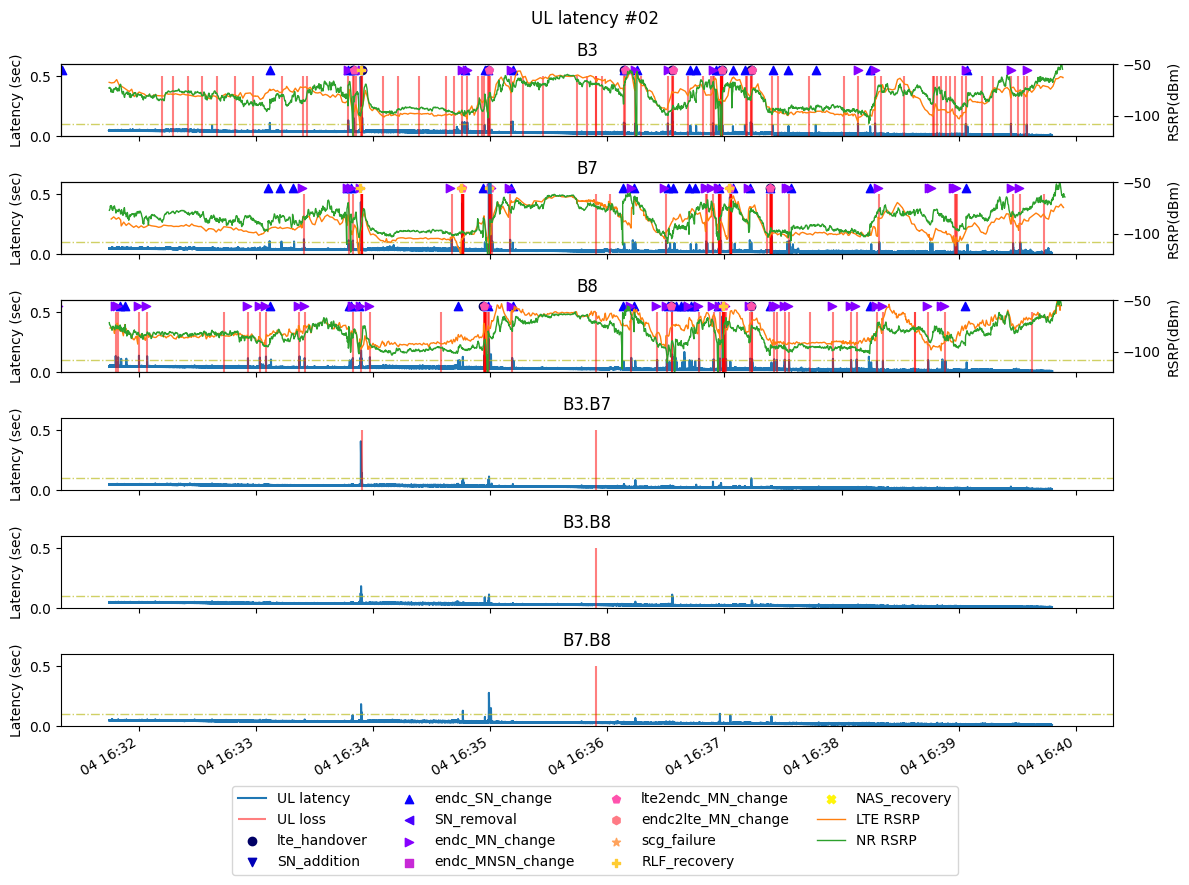

In [153]:
fig, axs = plt.subplots(6,1, figsize=(12, 8), sharex=True)
# fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()


lte_rsrp_dfs = [*lte_rsrp_dfs, 0, 0, 0]
nr_rsrp_dfs = [*nr_rsrp_dfs, 0, 0, 0]
for i, (df, df2, df3, df4, tag) in enumerate(zip(UL_latency_dfs, UL_loss_dfs, lte_rsrp_dfs, nr_rsrp_dfs, set_dev)):
    if i < 3:
        df = df[df['lost'] == False]
        x = df["Timestamp"].iloc[:]
        y = df["latency"].iloc[:]
        axs[i].plot(x, y, label='UL latency') # Latency
        axs[i].set_ylim([0, 0.6])
        
        axs[i].axhline(0.1, c='tab:olive', alpha=0.7, linestyle='-.', linewidth=1.0)

        df2 = df2[df2['lost'] == True]
        x2 = df2["Timestamp"].iloc[:]
        axs[i].vlines(x2,ymin=0, ymax=0.5, color='r', label='UL loss', alpha=0.5)
        
        ax = axs[i].twinx()
        ax.set_ylim([-120, -50])
        ax.set_ylabel('RSRP(dBm)')
        df3 = df3[df3['Timestamp'] > df.at[0, "Timestamp"]]
        x3 = df3["Timestamp"].iloc[:]
        y3 = df3["RSRP(dBm)"].iloc[:].astype(float)
        lte_rsrp_plot, = ax.plot(x3, y3, c='tab:orange', label='LTE RSRP', linewidth=1.0) # LTE RSRP
        
        df4 = df4[df4['Timestamp'] > df.at[0, "Timestamp"]]
        x4 = df4["Timestamp"].iloc[:]
        y4 = df4["RSRP(dBm)"].iloc[:].astype(float)
        nr_rsrp_plot, = ax.plot(x4, y4, c='tab:green', label='NR RSRP', linewidth=1.0) # NR RSRP
    else:
        df = df[df[f'lost.{tag}'] == False]
        x = df["Timestamp"].iloc[:]
        y = df[f"latency.{tag}"].iloc[:]
        axs[i].plot(x, y, label='UL latency') # Latency
        axs[i].set_ylim([0, 0.6])
        
        axs[i].axhline(0.1, c='tab:olive', alpha=0.7, linestyle='-.', linewidth=1.0)

        df2 = df2[df2[f'lost.{tag}'] == True]
        x2 = df2["Timestamp"].iloc[:]
        axs[i].vlines(x2,ymin=0, ymax=0.5, color='r', label='UL loss', alpha=0.5)
    

left, right = axs[0].get_xlim()
plot = []
plot = ['lte', 'nr_setup', 'nr_rel', 'gNB_ho', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail']
plabels = ['lte_handover', 'SN_addition', 'SN_removal', 'endc_SN_change', 'endc_MN_change', 'endc_MNSN_change', 'lte2endc_MN_change', 'endc2lte_MN_change', 'scg_failure', 'RLF_recovery', 'NAS_recovery']
pdict = {k : l for k, l in zip(plot, plabels)}
# plot = ['lte','MN_changed','eNB to MN changed','type2 fail','type3 fail']
# plot = ['type2 fail','type3 fail','gNB fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB']
# plot = ['SCell_add_rel']
# color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']

cmap = bpy_color_palette(11, 0.2)
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
markers = ['o', 'v', '^', '<', '>', 's', 'p', 'h', '*', 'P', 'X']
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            y = [0.55]*len(x)
            # axs[i].vlines(x,ymin=0, ymax=1, color=color[j], label=event)
            # axs[i].scatter(x, y, marker=markers[j], c=colors[j], label=event)
            axs[i].scatter(x, y, marker=markers[j], c=colors[j], label=pdict[event])
    axs[i].set_xlim([left, right])

handles, labels = axs[0].get_legend_handles_labels()
handles += [lte_rsrp_plot, nr_rsrp_plot]
labels += ['LTE RSRP', 'NR RSRP']
# print(handles, labels)
# axbox = axs[3].get_position()
axbox = axs[5].get_position()
fig.legend(
    handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.31,1,1],
    ncol=4,
)

for i, name in enumerate(set_dev):
    axs[i].set_title(name)
    axs[i].set_ylabel("Latency (sec)")

fig.suptitle('UL latency {}'.format(trace[0]))
fig.tight_layout()

In [154]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail'])

### DL

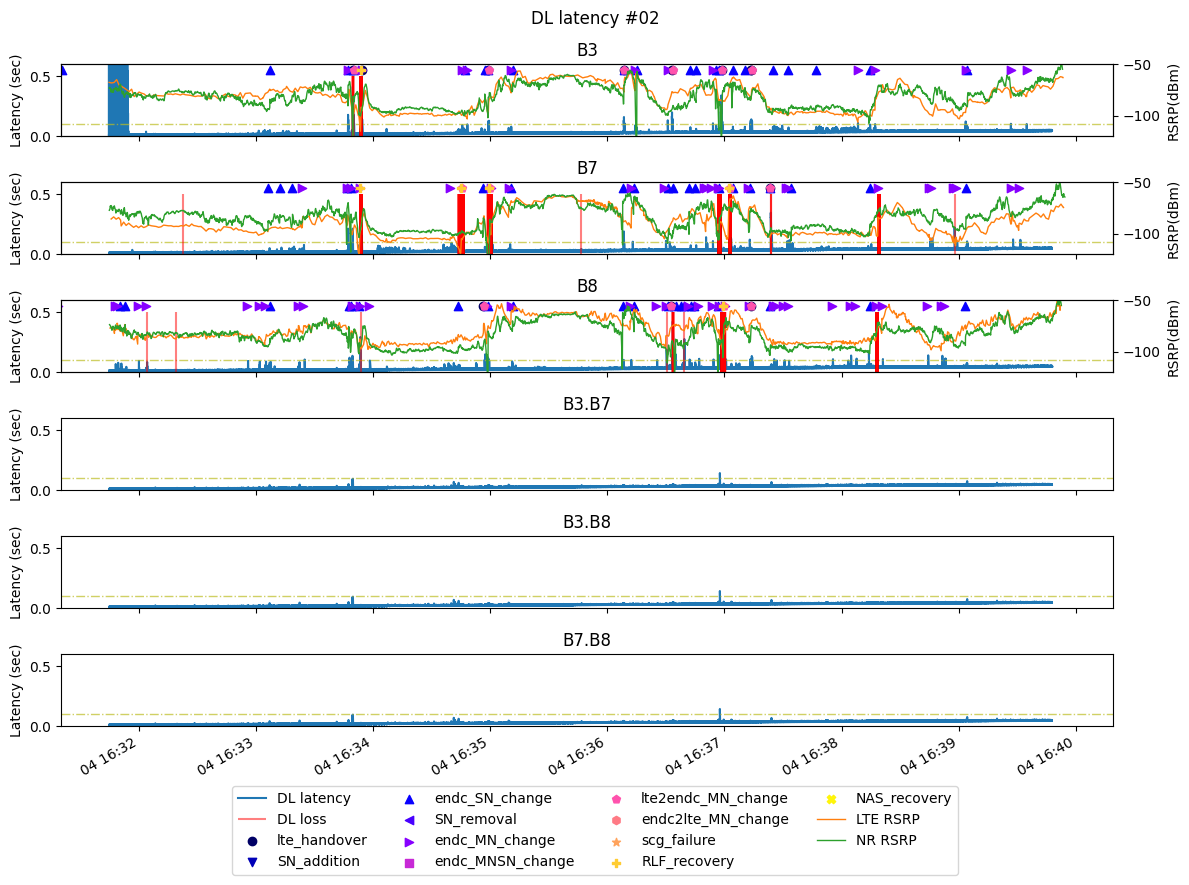

In [155]:
fig, axs = plt.subplots(6,1, figsize=(12, 8), sharex=True)
# fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()

for i, (df, df2, df3, df4) in enumerate(zip(DL_latency_dfs, DL_loss_dfs, lte_rsrp_dfs, nr_rsrp_dfs)):
    if i < 3:
        df = df[df['lost'] == False]
        x = df["Timestamp"].iloc[:]
        y = df["latency"].iloc[:]
        axs[i].plot(x, y, label='DL latency') # Latency
        axs[i].set_ylim([0, 0.6])
        
        axs[i].axhline(0.1, c='tab:olive', alpha=0.7, linestyle='-.', linewidth=1.0)

        df2 = df2[df2['lost'] == True]
        x2 = df2["Timestamp"].iloc[:]
        axs[i].vlines(x2,ymin=0, ymax=0.5, color='r', label='DL loss', alpha=0.5) # Loss
        
        ax = axs[i].twinx()
        ax.set_ylim([-120, -50])
        ax.set_ylabel('RSRP(dBm)')
        df3 = df3[df3['Timestamp'] > df.at[0, "Timestamp"]]
        x3 = df3["Timestamp"].iloc[:]
        y3 = df3["RSRP(dBm)"].iloc[:].astype(float)
        lte_rsrp_plot, = ax.plot(x3, y3, c='tab:orange', label='LTE RSRP', linewidth=1.0) # LTE RSRP
        
        df4 = df4[df4['Timestamp'] > df.at[0, "Timestamp"]]
        x4 = df4["Timestamp"].iloc[:]
        y4 = df4["RSRP(dBm)"].iloc[:].astype(float)
        nr_rsrp_plot, = ax.plot(x4, y4, c='tab:green', label='NR RSRP', linewidth=1.0) # NR RSRP
    else:
        df = df[df[f'lost.{tag}'] == False]
        x = df["Timestamp"].iloc[:]
        y = df[f"latency.{tag}"].iloc[:]
        axs[i].plot(x, y, label='UL latency') # Latency
        axs[i].set_ylim([0, 0.6])
        
        axs[i].axhline(0.1, c='tab:olive', alpha=0.7, linestyle='-.', linewidth=1.0)

        df2 = df2[df2[f'lost.{tag}'] == True]
        x2 = df2["Timestamp"].iloc[:]
        axs[i].vlines(x2,ymin=0, ymax=0.5, color='r', label='UL loss', alpha=0.5)
    

left, right = axs[0].get_xlim()
plot = []
plot = ['lte', 'nr_setup', 'nr_rel', 'gNB_ho', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail']
plabels = ['lte_handover', 'SN_addition', 'SN_removal', 'endc_SN_change', 'endc_MN_change', 'endc_MNSN_change', 'lte2endc_MN_change', 'endc2lte_MN_change', 'scg_failure', 'RLF_recovery', 'NAS_recovery']
pdict = {k : l for k, l in zip(plot, plabels)}
# plot = ['lte','MN_changed','eNB to MN changed','type2 fail','type3 fail']
# plot = ['type2 fail','type3 fail','gNB fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB']
# plot = ['SCell_add_rel']
# color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']

cmap = bpy_color_palette(11, 0.2)
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
markers = ['o', 'v', '^', '<', '>', 's', 'p', 'h', '*', 'P', 'X']
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            y = [0.55]*len(x)
            # axs[i].vlines(x,ymin=0, ymax=1, color=colors[j], label=event)
            # axs[i].scatter(x, y, marker=markers[j], c=colors[j], label=event)
            axs[i].scatter(x, y, marker=markers[j], c=colors[j], label=pdict[event])
    axs[i].set_xlim([left, right])

handles, labels = axs[0].get_legend_handles_labels()
handles += [lte_rsrp_plot, nr_rsrp_plot]
labels += ['LTE RSRP', 'NR RSRP']
# print(handles, labels)
# axbox = axs[3].get_position()
axbox = axs[5].get_position()
fig.legend(
    handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.31,1,1],
    ncol=4,
)

for i, name in enumerate(set_dev):
    axs[i].set_title(name)
    axs[i].set_ylabel("Latency (sec)")

fig.suptitle('DL latency {}'.format(trace[0]))
fig.tight_layout()